## Midterm 2
### Assigment 4
Author: Vojtech Orava

---------

Assigment details:

Implement a Bayesian Network (BN) comprising at least 10 nodes, all with binomial or multinomial distribution. Represent the BN with the data structures that you deem appropriate and in the programming language that you prefer. The BN should model some problem/process of your choice, so you are also free to define the topology according to your prior knowledge (just be ready to justify your choices). For instance, you can define a BN to represent a COVID diagnosis through a certain number of events/exams/symptoms: e.g. Cough, Cold, Fever, Breathing problems, Swab Exam, etc. Or you can model your daily routine: Wakeup, Coffee, Toilet, Study, Lunch, etc.
Once you have modelled the BN, also plug in the necessary local conditional probability tables. You can set the values of the probabilities following your own intuition on the problem (ie no need to learn them from data). Then run some episoded of Ancestral Sampling on the BN and discuss the results.

In [1]:
!wget -O BN.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1kwb02eCS173hXV3b1w5nrXaG1i0z0tpk'


will be placed in the single file you specified.

--2025-06-23 13:59:50--  https://drive.google.com/uc?export=download&id=1kwb02eCS173hXV3b1w5nrXaG1i0z0tpk
Resolving drive.google.com (drive.google.com)... 74.125.26.102, 74.125.26.139, 74.125.26.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1kwb02eCS173hXV3b1w5nrXaG1i0z0tpk&export=download [following]
--2025-06-23 13:59:50--  https://drive.usercontent.google.com/download?id=1kwb02eCS173hXV3b1w5nrXaG1i0z0tpk&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.196.132, 2607:f8b0:400c:c36::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.196.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291444 (285K) [image/png]
Saving to: ‘BN.png’

BN.png              100%[=================

## Solution

I decided to create Bayesian Network (BN) which will be modeling decision for transportation type (bus, car, train). There are 10 nodes (Financial situation, Comfortness, Reliability, Residence, Ecology, Price, Availability, Time, Other traffic situation, Type of transportation) in created BN with the structure and probabilities displayed in image below. This structure and choosen probabilities will be explained later.


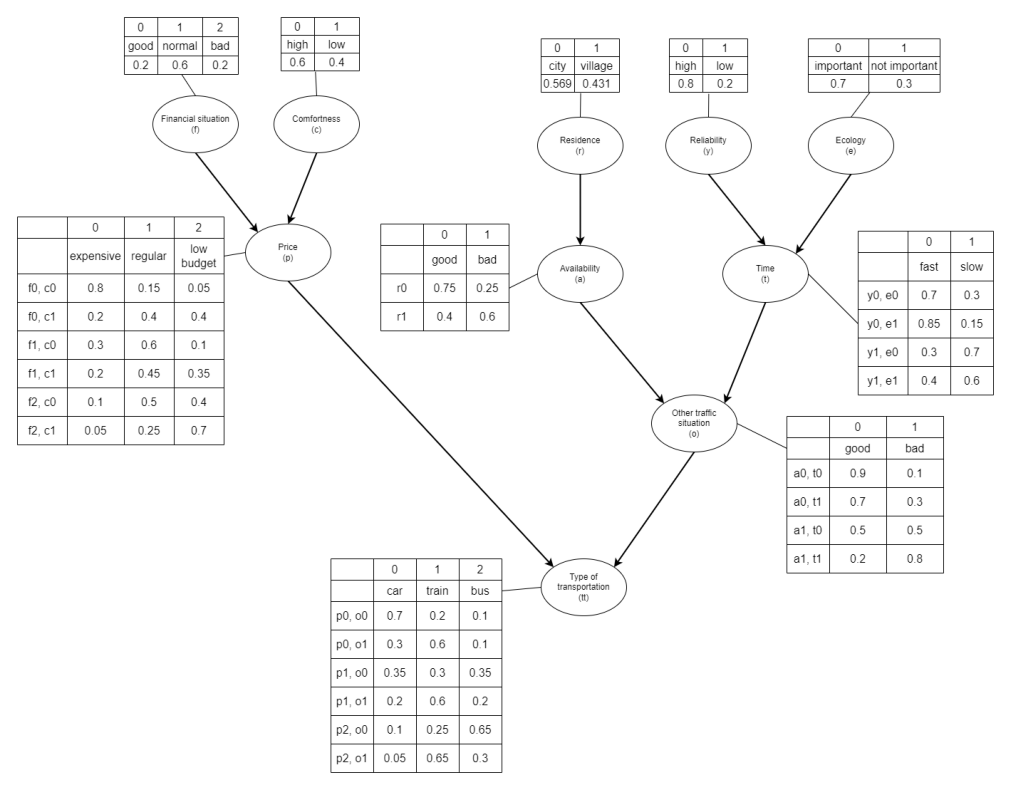

In [2]:
# for random choices
import random
from tabulate import tabulate
# just to display image with structure of Bayesian network
import matplotlib.pyplot as plt
import cv2

bnpng = cv2.cvtColor(cv2.imread("BN.png"), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(bnpng)
ax.axis("off")
ax.plot()
plt.show()

We need to have 2 classes:

- Node
- BayesianNetwork

**Node** class consists of name of node, values (e.g. "good", "bad"), list of parent nodes and probabilities.

Object of class **BayesianNetwork** is collecting all nodes and provides few functions: topological sort and function to proccess ancestral sampling.

In [3]:
class Node:
    def __init__(self, name, values, probabilities=dict(), parents=list()):
        self.name = name
        self.values = values
        self.parents = parents
        self.probabilities = {}
        self.probabilities[tuple([])] = probabilities

    def set_probability(self, parent_val, probabilities):
        self.probabilities[tuple(parent_val)] = probabilities

    def get_probability(self, parent_values):
        return self.probabilities.get(tuple(parent_values))

In [4]:
class BayesianNetwork:
    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.name] = node

    def add_nodes(self, nodes):
        for n in nodes:
            self.nodes[n.name] = n

    def sort_nodes(self):
        sorted_nodes = []
        seen_nodes = set()

        for node in self.nodes.values():
            self.seen(node, seen_nodes, sorted_nodes)

        return sorted_nodes

    def seen(self, node, seen_nodes, sorted_nodes):
        if node not in seen_nodes:
            seen_nodes.add(node)
            for parent in node.parents:
                self.seen(parent, seen_nodes, sorted_nodes)
            sorted_nodes.append(node)


    def sample(self):
        arr = {}
        sample = {}

        # sample nodes in topological order
        for node in self.sort_nodes():
            sample[node.name] = self.sample_node(node, arr)
            arr[node] = sample[node.name]

        return sample

    def sample_node(self, node, evidence):
        parent_values = [evidence[parent] for parent in node.parents]
        #print(f"Parent values {parent_values}")
        probabilities = node.get_probability(parent_values)
        return random.choices(node.values, weights=probabilities)[0]


### Nodes creation

Below follows creation of all nodes. The meaning of the nodes are:

- Financial situation: defines financial capability of traveller
- Comfortness: says if traveller needs high comfort while travelling
- Reliability: defines demanded transport reliability
- Residence: there could be worse traffic connection from village
- Ecology: travellers opinion about ecology of transport
- Price: how much money is traveller willing to spend
- Availability: defines avalaibility of different types of transportation
- Time: says how much is time of travel important for traveller
- Other traffic situation: is there a traffic jam?
- Type of transportation: says which type of transportation is probably best

At the top level nodes the probabilities are defined here (and explained as python comments). At the nodes with some parent(s), these parents are defined also here. Probabilities for these nodes are written in the next cell.

In [5]:
financial_situation = Node(
    "Financial situation", # name
    ["good", "normal", "bad"], # values
    [0.2, 0.6, 0.2] # probabilities
    # [1.0, 0.0, 0.0] # always set good financial situation - more about that below
    # most people are in normal financial situation
    # parents
)
comfortness = Node(
    "Comfortness",
    ["high", "low"],
    [0.6, 0.4]  # more people are satisfied with less comfort and less price
    # [1.0, 0.0]  # always set high comfort - more about that below
)
reliability = Node(
    "Reliability",
    ["high", "low"],
    [0.8, 0.2] # people want transport to be reliable and not disrupt their plans
)
residence = Node(
    "Residence",
    ["city", "village"],
    [0.569, 0.431]  # based on statistics on web page
    # https://www.statista.com/statistics/1328171/rural-population-worldwide/
    # 43.1 % of people live in village
)
ecology = Node(
    "Ecology",
    ["important", "not important"],
    [0.7, 0.3]  # we want to travel to be ecologic (train is more ecologic than car)
)
###############################################################
price = Node(
    "Price",
    ["expensive", "regular", "low budget"],
    parents=[financial_situation, comfortness]  # how much travel can cost is depending on financial situation and demanded comfort
)
availability = Node(
    "Availability",
    ["good", "bad"],
    parents=[residence]
)
time = Node(
    "Time",
    ["fast", "slow"],
    parents=[reliability, ecology] # transport time could vary based on starting point (city/village)
    # and also on required ecology
)
other_traffic = Node(
    "Other traffic situation",
    ["good", "bad"],
    parents=[availability, time]
)
type_of_transportation = Node(
    "Type of transportation",
    ["car", "bus", "train"],
    parents=[price, other_traffic]
)

### Conditional probabilities

In the code cells below are defined conditional and joint probabilities for all combinations.

For **price**, values are *expensive*, *regular* and *low budget*.  For all probabilities below we can say that if we choose to travel with high comfort and we have a lot of money, most likely the price will be higher and viceversa.

In [6]:
# parent1 = financial_situation (good), parent2 = comfortness (high)
price.set_probability(
    ["good", "high"],
    [0.8, 0.15, 0.05]
)

# parent1 = financial_situation (good), parent2 = comfortness (low)
price.set_probability(
    ["good", "low"],
    [0.2, 0.4, 0.4]
)

# parent1 = financial_situation (normal), parent2 = comfortness (high)
price.set_probability(
    ["normal", "high"],
    [0.3, 0.6, 0.1]
)

# parent1 = financial_situation (normal), parent2 = comfortness (low)
price.set_probability(
    ["normal", "low"],
    [0.2, 0.45, 0.35]
)

# parent1 = financial_situation (bad), parent2 = comfortness (high)
price.set_probability(
    ["bad", "high"],
    [0.1, 0.5, 0.4]
)

# parent1 = financial_situation (bad), parent2 = comfortness (low)
price.set_probability(
    ["bad", "low"],
    [0.05, 0.25, 0.7]
)

**Availabity** has 2 values: *good* or *bad*. Living in the city provides better transport availability.

In [7]:
# parent1 = residence (city)
availability.set_probability(
    ["city"],
    [0.75, 0.25]
)

# parent1 = residence (village)
availability.set_probability(
    ["village"],
    [0.4, 0.6]
)


**Time** that transport will take is either **fast** or **slow**. With higher reliability time increase.

In [8]:
# parent1 = reliability (high), parent2 = ecology (important)
time.set_probability(
    ["high", "important"],
    [0.7, 0.3]
)

# parent1 = reliability (high), parent2 = ecology (not important)
time.set_probability(
    ["high", "not important"],
    [0.85, 0.15]
)

# parent1 = reliability (low), parent2 = ecology (important)
time.set_probability(
    ["low", "important"],
    [0.3, 0.7]
)

# parent1 = reliability (low), parent2 = ecology (not important)
time.set_probability(
    ["low", "not important"],
    [0.4, 0.6]
)


**Other traffic situation** could be *good* or *bad*. Better availability and faster needed time implicts better other traffic situation.

In [9]:

# parent1 = availability (good), parent2 = time (fast)
other_traffic.set_probability(
    ["good", "fast"],
    [0.9, 0.1]
)

# parent1 = availability (good), parent2 = time (slow)
other_traffic.set_probability(
    ["good", "slow"],
    [0.7, 0.3]
)

# parent1 = availability (bad), parent2 = time (fast)
other_traffic.set_probability(
    ["bad", "fast"],
    [0.5, 0.5]
)

# parent1 = availability (bad), parent2 = time (slow)
other_traffic.set_probability(
    ["bad", "slow"],
    [0.2, 0.8]
)

**Type of transportation** says which transport should be choosen: *car*/*bus*/*train*. Car ensures freedom but could be more expensive and is very dependent on other traffic (like traffic jams). Train could be cheaper and more trouble-free. Bus is definitely cheaper than car but is also dependent on other traffic.

In [10]:
# parent1 = price (expensive), parent2 = other_traffic (good)
type_of_transportation.set_probability(
    ["expensive", "good"],
    [0.7, 0.2, 0.1]
)
# parent1 = price (expensive), parent2 = other_traffic (bad)
type_of_transportation.set_probability(
    ["expensive", "bad"],
    [0.3, 0.6, 0.1]
)
# parent1 = price (regular), parent2 = other_traffic (good)
type_of_transportation.set_probability(
    ["regular", "good"],
    [0.35, 0.3, 0.35]
)
# parent1 = price (regular), parent2 = other_traffic (bad)
type_of_transportation.set_probability(
    ["regular", "bad"],
    [0.2, 0.6, 0.2]
)
# parent1 = price (low budget), parent2 = other_traffic (good)
type_of_transportation.set_probability(
    ["low budget", "good"],
    [0.1, 0.25, 0.65]
)
# parent1 = price (low budget), parent2 = other_traffic (bad)
type_of_transportation.set_probability(
    ["low budget", "bad"],
    [0.05, 0.65, 0.3]
)

### Ancestral sampling

In this part, ancestral sampling is done and results are printed in the table.

In [11]:
# create the Bayesian network
bn = BayesianNetwork()
bn.add_nodes([financial_situation, comfortness, residence, reliability, ecology, price, availability, time, other_traffic, type_of_transportation])
output = []

# ancestral sampling
for _ in range(10):  # 10 episodes
    run = {}
    sample = bn.sample()
    for node_name, value in sample.items():
        run[node_name] = value

    output.append(run)


In [12]:
headers = list(output[0].keys())
rows = [[row[key] for key in headers] for row in output]
print("Ancestral Sampling results:")
print(tabulate(rows, headers=headers, tablefmt="grid"))


Ancestral Sampling results:
+-----------------------+---------------+-------------+---------------+---------------+------------+----------------+--------+---------------------------+--------------------------+
| Financial situation   | Comfortness   | Residence   | Reliability   | Ecology       | Price      | Availability   | Time   | Other traffic situation   | Type of transportation   |
+=======================+===============+=============+===============+===============+============+================+========+===========================+==========================+
| bad                   | high          | village     | high          | not important | regular    | bad            | fast   | good                      | car                      |
+-----------------------+---------------+-------------+---------------+---------------+------------+----------------+--------+---------------------------+--------------------------+
| normal                | low           | city        | high  

### Result interpretation and discussion

We can see that implemented Bayesian network is outputing all possible outcomes from the result, so none of the transportation posibilities is being neglected. If probabilites were learned from data, the network could be used in real cases. Interesting fact is that, when we set probabilities of some nodes to 1.0 for only one value, results are distributed diferently ((un)comment **financial_situation** and **comforteness** probabilities distributions to try - result *train* should appear less times).

The strucuture of created BN was done just by my own intuition, so connecting nodes differently could produces better/worse results. Ancestral sampling could be used as a comparing algorithm between these BNs.